# Fairness measurement in imbalance UTK Dataset

## Setup

### Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, recall_score, roc_curve, multilabel_confusion_matrix, confusion_matrix
import copy
import matplotlib.patches as mpatches

#Metrics
from lib.metrics import *
#Utils
from lib.utils import *
#Properties
from lib.utils import properties as p
#Model
import lib.nn_model as nn

### Config

In [2]:
#Config
%config InlineBackend.figure_format='retina'
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Preparation

### Setup properties

In [3]:
p.update({
    
    #Age range
    'age_min' : 0,
    'age_max' : 39,
    
    #Number of data samples
    'data_samples' : 20000
    
})

### Read data

In [4]:
df = pd.read_csv('../dataset/data.csv')

### Prepare dataset

In [5]:
#Remove other ethnicities
del p['ETHNICITIES'][4]
df = df[df['ethnicity'] != 4]
#print_summary(df)

### Filters for data manipulation

In [6]:
def age_filter(df, age_min, age_max):
    return (df['age'] >= age_min) & (df['age'] <= age_max)

def ethnicity_gender_filter(df, i, j):
    return (df['ethnicity'] == p['ETHNICITIES'][i]) & (df['gender'] == p['GENDERS'][j])

def ethnicity_age_filter(df, e, age_min, age_max):
    return (df['ethnicity'] == p['ETHNICITIES'][e]) & age_filter(df, age_min, age_max)

def ethnicity_gender_age_filter(df, i, j, age_min, age_max):
    return ethnicity_gender_filter(df, i, j) & age_filter(df, age_min, age_max)

### Dataset preparation

In [7]:
#Prepare
df = df.loc[age_filter(df, p['age_min'], p['age_max'])]
df['ethnicity'] = df['ethnicity'].map(p['ETHNICITIES'])
df['gender'] = df['gender'].map(p['GENDERS'])

### Create balanced dataset

In [8]:
#Ethnicity gender age sample size
ethnicity_age_sample_size = round(p['data_samples'] / (round(p['age_range']() / p['age_bins']) * len(p['ETHNICITIES'])))

balanced_df = pd.concat([
    df.loc[ethnicity_age_filter(df, e, age_m, age_M)]\
        .sample(ethnicity_age_sample_size, random_state=p['seed'], replace=True)
    for e in range(len(p['ETHNICITIES']))
    for (age_m, age_M) in p['bins']()
])

### Create unbalanced dataset

In [9]:
def create_unbalanced_set(df, minority_proportion=0.05, majority_group=0):
    min_factor = minority_proportion # 5% of the population 
    maj_factor = 1 - min_factor

    #Size of minority group
    min_sample_size = round(p['data_samples'] * min_factor / len(p['bins']()) / (len(p['ETHNICITIES']) - 1))

    #Size of majority group
    maj_sample_size = round(p['data_samples'] * maj_factor / len(p['GENDERS']) / len(p['bins']()))

    maj_male = pd.concat([
        df.loc[ethnicity_gender_age_filter(df, majority_group, 0, age_min, age_max)]\
            .sample(maj_sample_size, random_state=p['seed'], replace=True)
        for (age_min, age_max) in p['bins']()
    ])

    maj_female = pd.concat([
        df.loc[ethnicity_gender_age_filter(df, majority_group, 1, age_min, age_max)]\
            .sample(maj_sample_size, random_state=p['seed'], replace=True)
        for (age_min, age_max) in p['bins']()
    ])

    unbalanced_df = pd.concat([
        df.loc[ethnicity_age_filter(df, e, age_min, age_max)]\
            .sample(min_sample_size, random_state=p['seed'], replace=True)
        for e in range(len(p['ETHNICITIES']))
        #for j in range(len(GENDERS))
        for (age_min, age_max) in p['bins']()
        if e != majority_group
    ] + [maj_female, maj_male])
    
    return unbalanced_df

## Predictive Model

### Model

In [10]:
# network (not federated)

def standard_nn():
    return nn.get_standard_nn(p['seed'])

### Evaluation functions

In [11]:
def evaluate_ethnicity(dataset, ethnicity, df_test, model):
    ethn_y, ethn_y_pred = get_ethnicity_predictions(dataset, df_test, ethnicity, model)
    score = f1_score(convert_output(ethn_y), convert_output(ethn_y_pred), average='macro')
    return score

def evaluate_ethnicity_accuracy(dataset, ethnicity, df_test, model):
    ethn_y, ethn_y_pred = get_ethnicity_predictions(dataset, df_test, ethnicity, model)
    score = get_accuracy(convert_output(ethn_y), convert_output(ethn_y_pred))
    return score

def evaluate_all_ethnicities(dataset, df_test, model):
    scores = [evaluate_ethnicity(dataset, e, df_test, model) for e in p['ETHNICITIES'].values()]
    return dict(zip(p['ETHNICITIES'].values(), scores))

def evaluate_all_ethnicity_accuracy(dataset, df_test, model):
    scores = [evaluate_ethnicity_accuracy(dataset, e, df_test, model) for e in p['ETHNICITIES'].values()]
    return dict(zip(p['ETHNICITIES'].values(), scores))

def get_ethnicity_predictions(dataset, df_test, ethnicity, model):
    idx_keys = dataset.index.intersection(df_test[df_test['ethnicity'] == ethnicity].index)
    ethn_df = dataset.loc[idx_keys]
    ethn_X = prepare_X(ethn_df)
    ethn_y = prepare_y(ethn_df)         #y_true 
    ethn_y_pred = model.predict(ethn_X) #y_pred 
    return ethn_y, ethn_y_pred

def ethnicity_equal_odd_difference(dataset, df_test, ethnicity, model, privileged_group, ethn_y_p, ethn_y_p_pred):
    
    if ethnicity == privileged_group:
        return 0
    
    ethn_y_u, ethn_y_u_pred = get_ethnicity_predictions(dataset, df_test, ethnicity, model) #unprivileged
    
    return np.mean(equal_odd_difference(
        one_hot_vect_to_class(convert_output(ethn_y_p)), 
        one_hot_vect_to_class(convert_output(ethn_y_p_pred)), 
        one_hot_vect_to_class(convert_output(ethn_y_u)), 
        one_hot_vect_to_class(convert_output(ethn_y_u_pred))
    ))

def ethnicity_equality_metric(
    dataset, 
    df_test, 
    ethnicity, 
    model, 
    privileged_group, 
    ethn_y_p, 
    ethn_y_p_pred, 
    metric_fun):
    if ethnicity == privileged_group:
        return 0
    
    ethn_y_u, ethn_y_u_pred = get_ethnicity_predictions(dataset, df_test, ethnicity, model) #unprivileged
    
    return np.nanmean(metric_fun(
        one_hot_vect_to_class(convert_output(ethn_y_p)), 
        one_hot_vect_to_class(convert_output(ethn_y_p_pred)), 
        one_hot_vect_to_class(convert_output(ethn_y_u)), 
        one_hot_vect_to_class(convert_output(ethn_y_u_pred))
    ))

def all_ethnicity_equal_difference(
    dataset, df_test, model, privileged_group, ethn_y_p, ethn_y_p_pred, metric_fn_list
):
    scores = [
        np.nanmean(np.abs([
            ethnicity_equality_metric(
                dataset, 
                df_test, 
                e, 
                model, 
                privileged_group, 
                ethn_y_p, 
                ethn_y_p_pred,
                metric_fn
            ) 
            for e in p['ETHNICITIES'].values()
        ])) for metric_fn in metric_fn_list
    ]
    metrics_list = ['Abs avg. ' + m.__name__.replace('_', ' ').capitalize() for m in metric_fn_list]
    return dict(zip(metrics_list, scores)) # + scores_eodd

### Predictions and fairness measurements

In [12]:
def predict_and_evaluate(df, model, exp_id):
    
    privileged_group = df['ethnicity'].value_counts().idxmax() #Majority group (privileged)
    
    df_train, df_test = create_train_test(df)
    X_train, y_train, X_test, y_test = prepare_data(df_train, df_test)
    for i in range(len(X_train)):
        model.fit(X_train[i], y_train[i], epochs=p['epochs_n'], learning_rate=p['learning_rate'])
    
    y_pred = model.predict(X_test)
    ethn_y_p, ethn_y_p_pred = get_ethnicity_predictions(df, df_test, privileged_group, model) #privileged
    
    all_ethnicities_f1s = evaluate_all_ethnicities(df, df_test, model)
    all_ethnicities_acc = evaluate_all_ethnicity_accuracy(df, df_test, model)
    
    ev = dict()
    ev['experiment ID'] = exp_id
    ev['data sample #'] = round(len(df))
    ev['accuracy'] = get_accuracy(convert_output(y_test), convert_output(y_pred))
    ev['accuracy variance'] = macro_variance(ev['accuracy'], list(all_ethnicities_acc.values()))
    ev['f1'] = f1_score(convert_output(y_test), convert_output(y_pred), average='macro')
    ev['f1 variance'] = macro_variance(ev['f1'], list(all_ethnicities_f1s.values()))
    #ev.update(all_ethnicities_f1s)
    all_parities = all_ethnicity_equal_difference(
        df, df_test, model, privileged_group, ethn_y_p, ethn_y_p_pred,
        [
            disparate_impact_ratio, 
            statistical_parity_difference, 
            equal_opportunity_difference,
            equal_odd_difference
        ]
    )
    ev.update(all_parities)
    #ev['EOR'] = equal_opportunity_difference(convert_output(y_test), convert_output(y_pred))
    print_summary(df, exp_id)
    model.plot_accuracy_loss()
    
    return ev

def compare_model_behaviour(df_list, model_list, exp_ids):
    return [predict_and_evaluate(df_list[i], model_list[i], exp_ids[i]) for i in range(len(df_list))]

## Experiments

### Create balanced and imbalanced dataset for the experiments

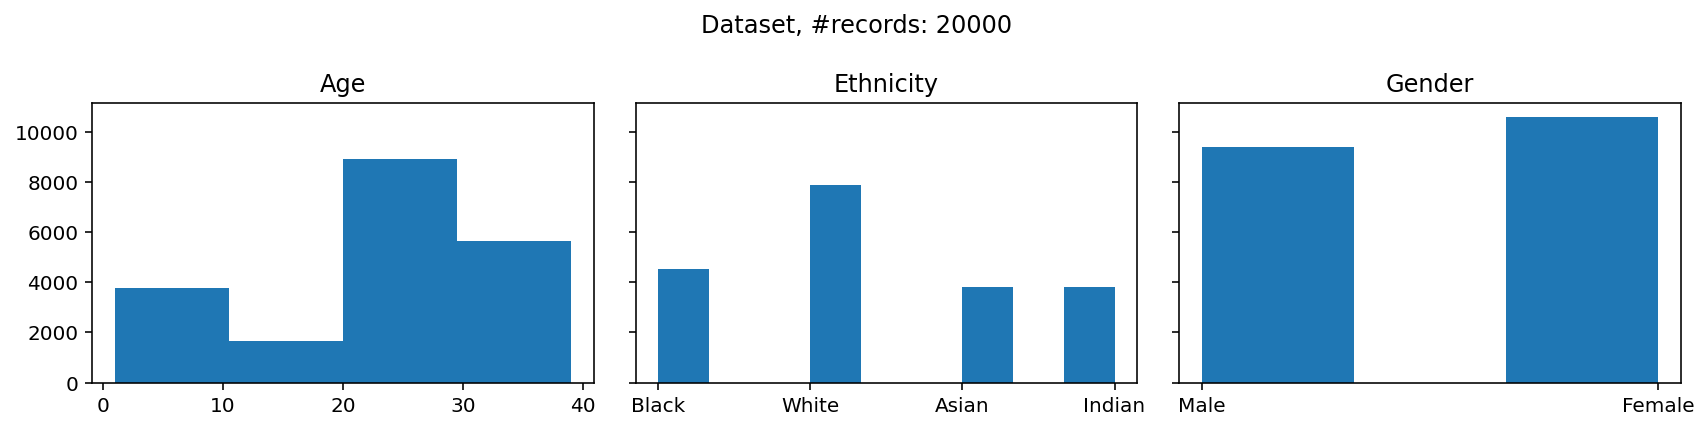

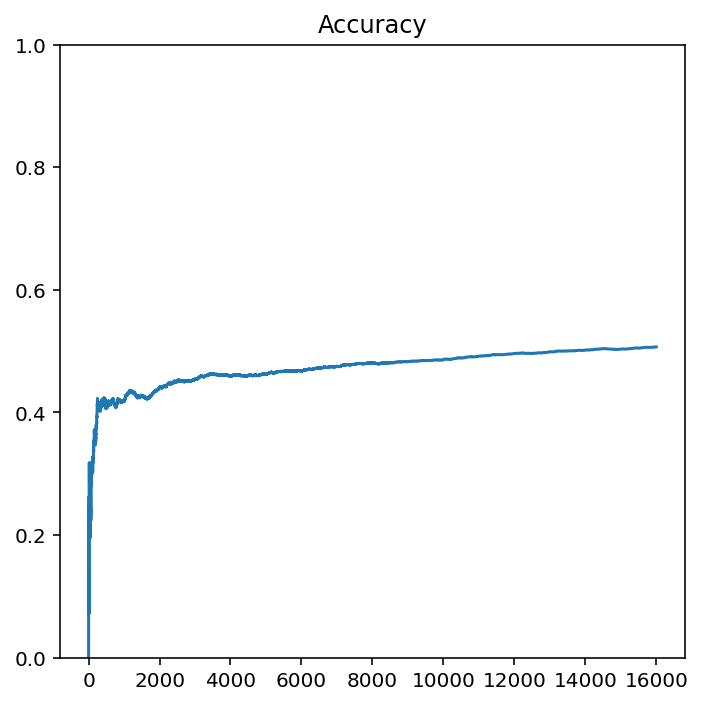

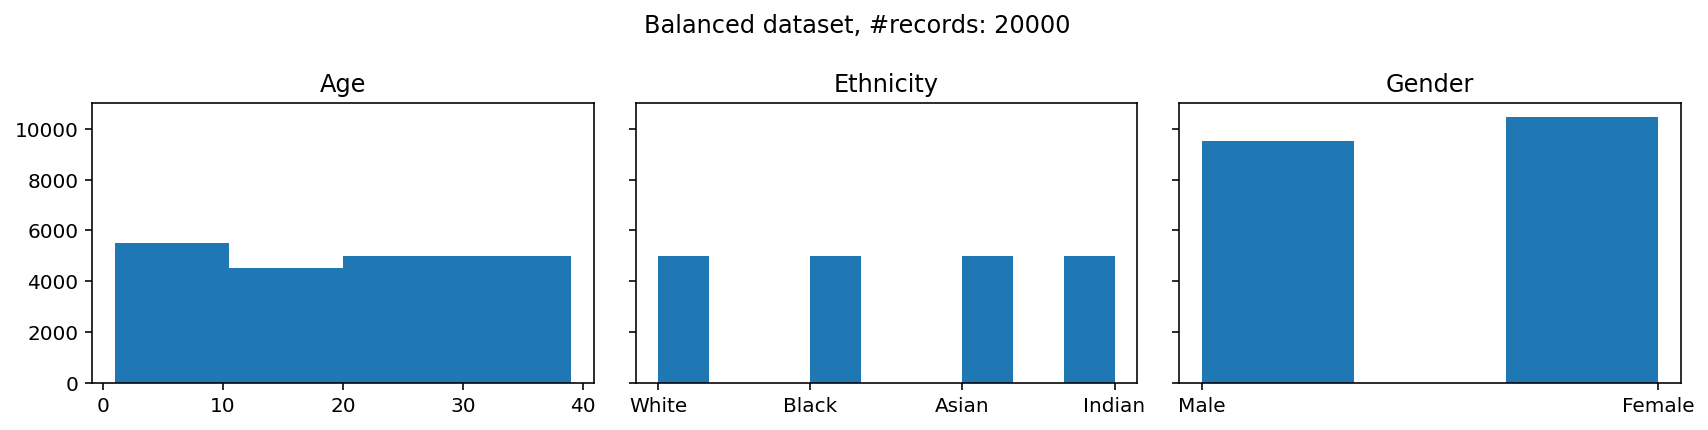

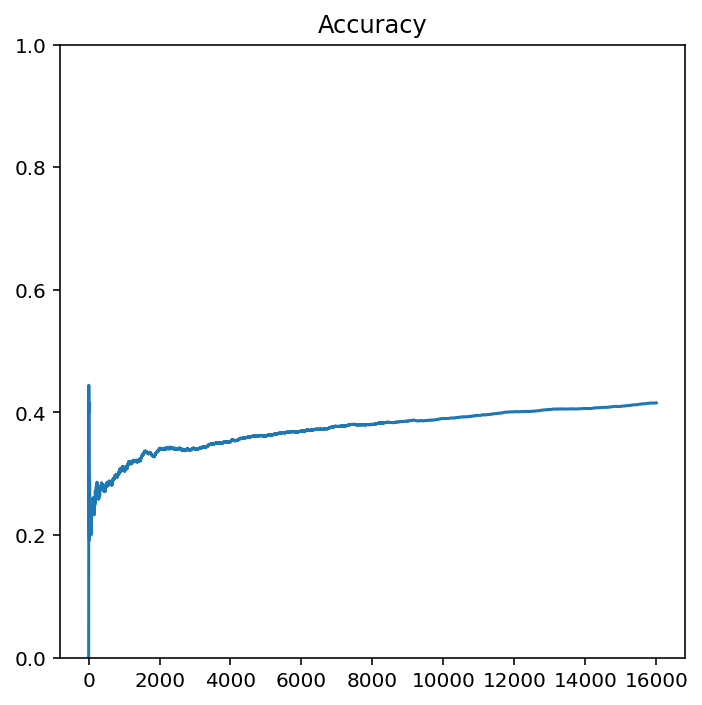

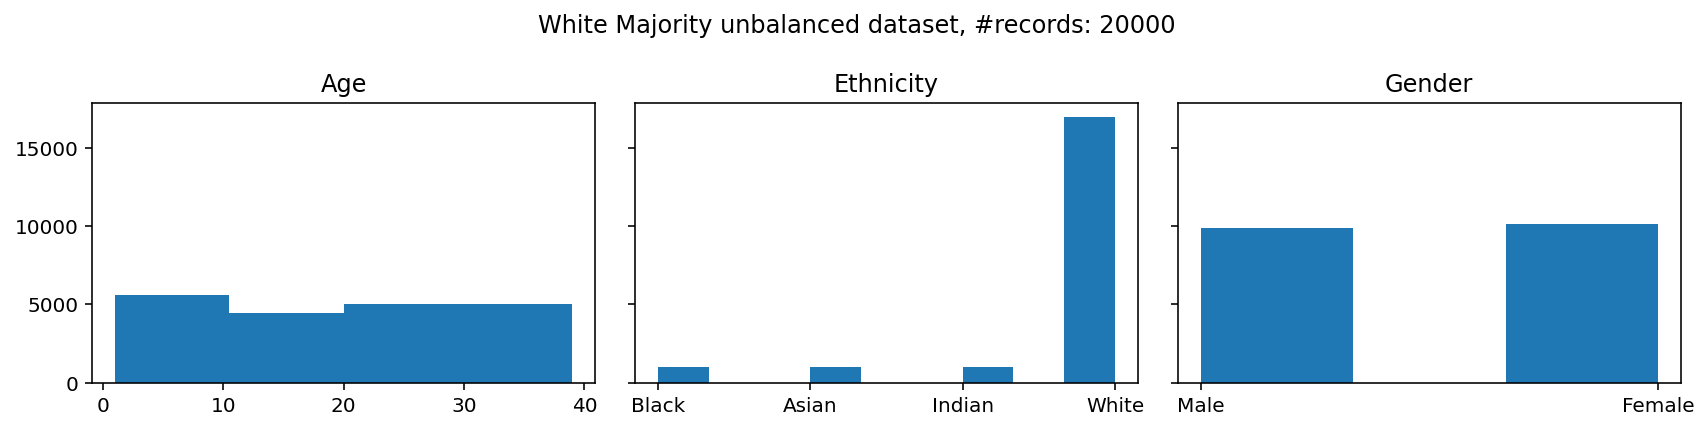

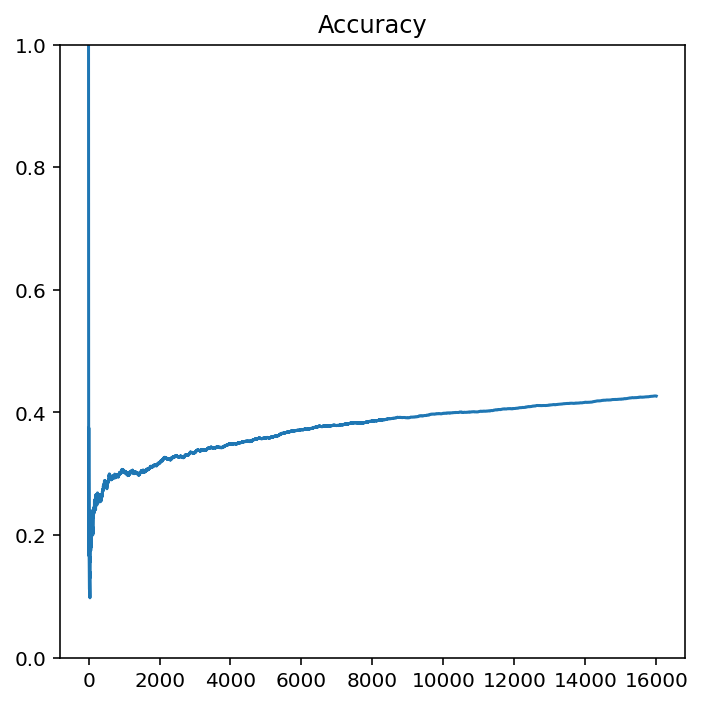

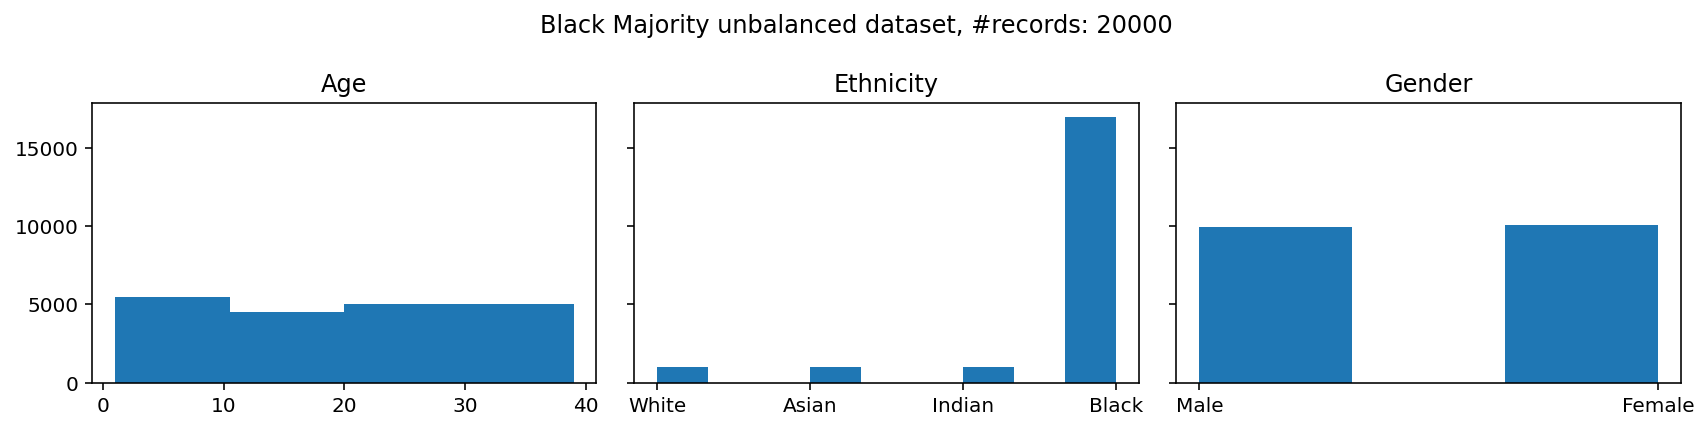

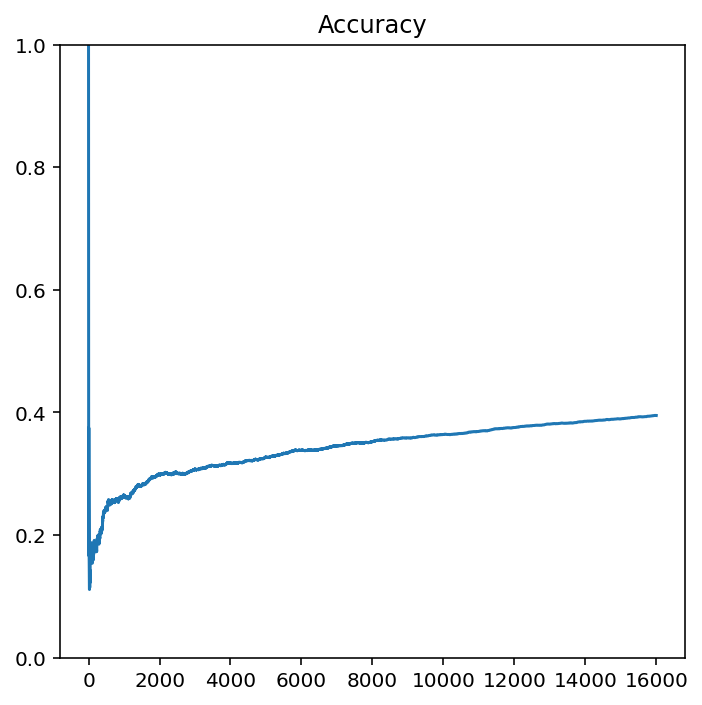

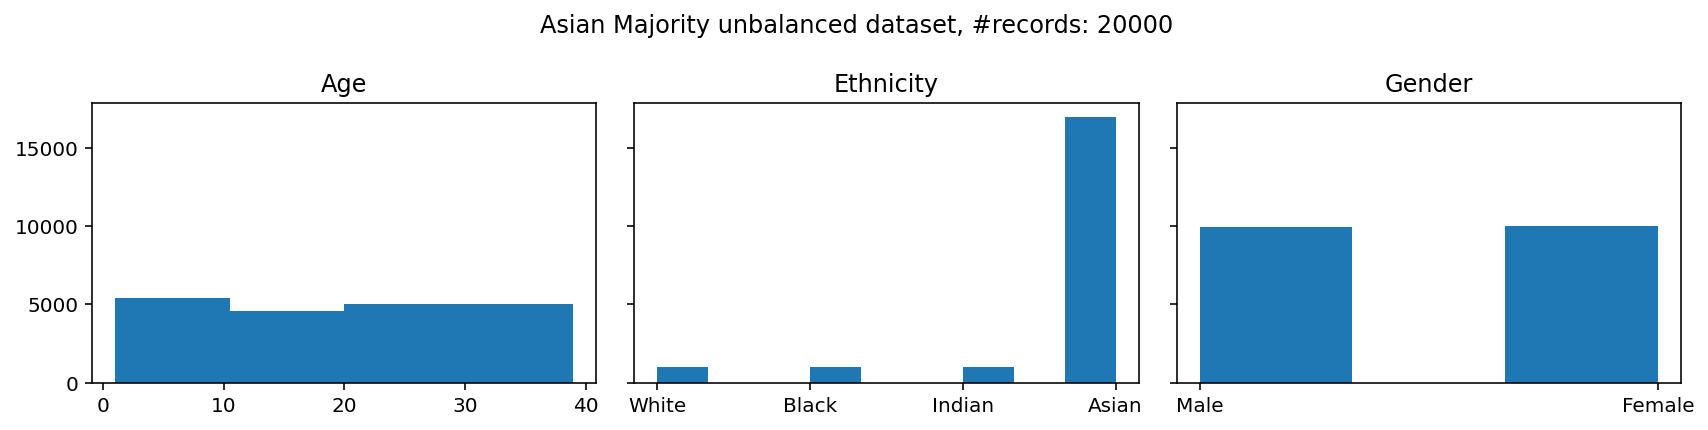

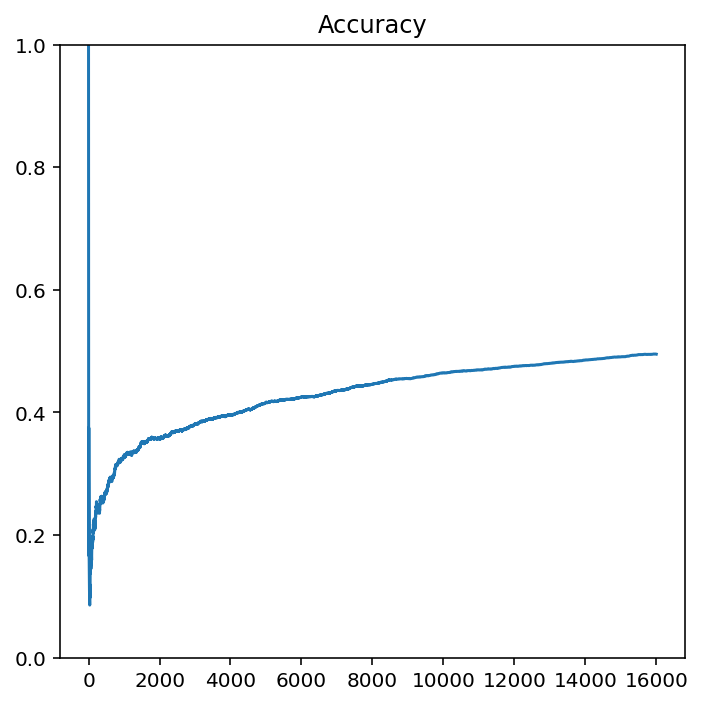

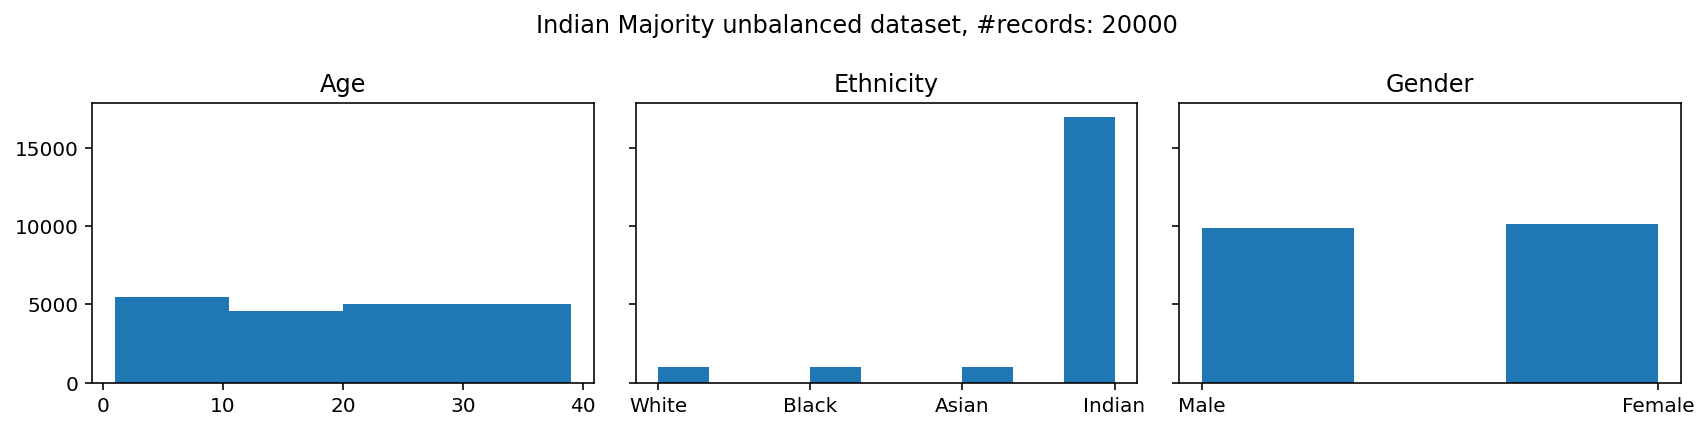

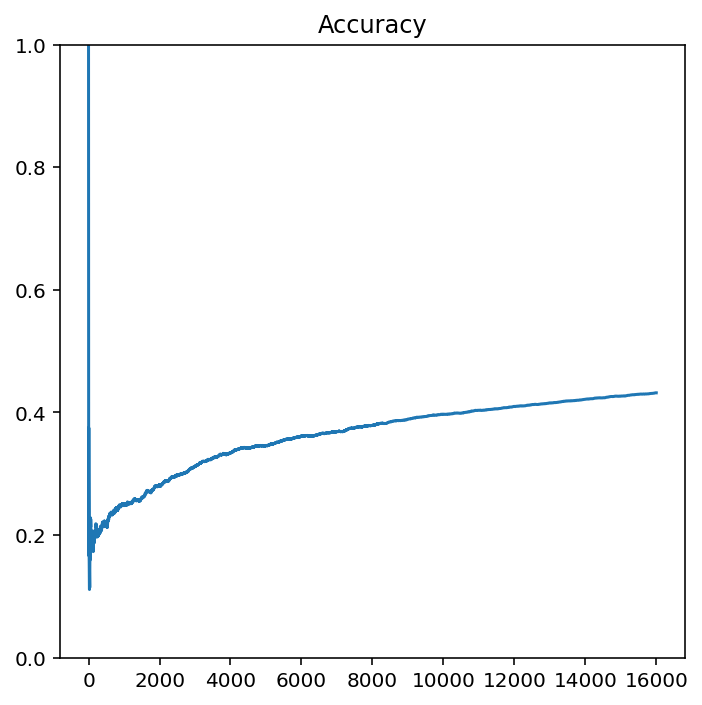

In [13]:
dfs = [
    df.sample(p['data_samples'], random_state=p['seed'], replace=True), #Sample of the actual set
    balanced_df                                                         #Artificial Balanced set
] + [
    create_unbalanced_set(df, 1 - p['privileged_group_proportion'], i)  #All minority groups set
    for i in p['ETHNICITIES'].keys()
]

models = []
for i in range(len(dfs)):
    models += [standard_nn()] 

exp_ids = ['Dataset', 'Balanced dataset'] + [
    p['ETHNICITIES'][i] + ' Majority unbalanced dataset'
    for i in p['ETHNICITIES'].keys()
]

metrics = compare_model_behaviour(
    dfs, 
    models,
    exp_ids
)

### Compute metrics

In [14]:
def get_metrics_data(metrics):
    metrics_df = pd.DataFrame()
    for m in metrics:
        row = pd.Series(m)
        metrics_df = metrics_df.append(row, ignore_index=True)
    return metrics_df

### Show results

In [15]:
%%notify
print(f'Epochs: {p["epochs_n"]}, lr: {p["learning_rate"]}, privileged proportion: {p["privileged_group_proportion"]}%')
get_metrics_data(metrics)

Epochs: 1, lr: 0.025, privileged proportion: 0.85%


,experiment ID,data sample #,accuracy,accuracy variance,f1,f1 variance,Abs avg. Disparate impact ratio,Abs avg. Statistical parity difference,Abs avg. Equal opportunity difference,Abs avg. Equal odd difference
0,Dataset,20000.0,0.55600,0.011250,0.374723,0.004100,0.965953,0.103608,0.041375,0.019737
1,Balanced dataset,20000.0,0.44425,0.000931,0.413695,0.003267,0.761929,0.018169,0.046086,0.018481
2,White Majority unbalanced dataset,20000.0,0.50150,0.000637,0.489900,0.002073,0.713183,0.018521,0.027929,0.013269
3,Black Majority unbalanced dataset,20000.0,0.46300,0.012268,0.435577,0.013782,0.526779,0.116312,0.066612,0.016999
4,Asian Majority unbalanced dataset,20000.0,0.55800,0.032209,0.550912,0.036201,0.490755,0.150245,0.150131,0.051769
5,Indian Majority unbalanced dataset,20000.0,0.52575,0.007242,0.509002,0.008665,0.602126,0.081584,0.057284,0.016954


<IPython.core.display.Javascript object>

### Get fairness increments

In [16]:
def get_perc_increment(row_before, row_after):
    perc_inc = (row_after - row_before) / np.abs(row_before) * 100
    return perc_inc
    
considered_metrics = ['accuracy', 
            'accuracy variance', 
            'f1', 'f1 variance', 
           'Abs avg. Statistical parity difference',
            'Abs avg. Equal opportunity difference',
            'Abs avg. Equal odd difference'
           ]

metrics_df = pd.DataFrame(metrics)

inc_df = pd.DataFrame([
    get_perc_increment(
        metrics_df.iloc[1][considered_metrics].values, 
        metrics_df.iloc[i][considered_metrics].values
    ) for i in range(2, len(metrics))
], columns=considered_metrics)

print('Means')
display(metrics_df[considered_metrics].mean())

print('Increment table from balance to imbalance')
display(inc_df)

print('Mean of increments')
display(inc_df.mean())

Means


accuracy                                  0.508083
accuracy variance                         0.010756
f1                                        0.462302
f1 variance                               0.011348
Abs avg. Statistical parity difference    0.081407
Abs avg. Equal opportunity difference     0.064903
Abs avg. Equal odd difference             0.022868
dtype: float64

Increment table from balance to imbalance


,accuracy,accuracy variance,f1,f1 variance,Abs avg. Statistical parity difference,Abs avg. Equal opportunity difference,Abs avg. Equal odd difference
0,12.886888,-31.578947,18.420605,-36.547291,1.940005,-39.397322,-28.204597
1,4.220597,1217.722879,5.289486,321.854913,540.168447,44.537813,-8.020545
2,25.604952,3359.613319,33.168769,1008.080808,726.932749,225.764231,180.121616
3,18.345526,677.873255,23.038096,165.228038,349.027222,24.297872,-8.264693


Mean of increments


accuracy                                    15.264491
accuracy variance                         1305.907626
f1                                          19.979239
f1 variance                                364.654117
Abs avg. Statistical parity difference     404.517106
Abs avg. Equal opportunity difference       63.800648
Abs avg. Equal odd difference               33.907945
dtype: float64

### equity degradation in imbalance dataset

In [17]:
bal = balanced_df

imb_a = create_unbalanced_set(df, 1 - p['privileged_group_proportion'], 2) #ASIAN-PR
imb_b = create_unbalanced_set(df, 1 - p['privileged_group_proportion'], 1) #BLACK-PR
imb_i = create_unbalanced_set(df, 1 - p['privileged_group_proportion'], 3) #INDIAN-PR
imb_w = create_unbalanced_set(df, 1 - p['privileged_group_proportion'], 0) #WHITE-PR
    
def get_inequity_score(dataset, model):
    scores = []
    privileged_group = dataset['ethnicity'].value_counts().idxmax() #Majority group (privileged)
    df_train, df_test = create_train_test(dataset)
    X_train, y_train, X_test, y_test = prepare_data(df_train, df_test)
    for i in range(len(X_train)):
        model.fit(X_train[i], y_train[i], epochs=p['epochs_n'], learning_rate=p['learning_rate'])
        if (i+1) % 250 == 0:
            ethn_y_p, ethn_y_p_pred = get_ethnicity_predictions(dataset, df_test, privileged_group, model)
            dif = all_ethnicity_equal_difference(
                dataset, df_test, model, privileged_group, ethn_y_p, ethn_y_p_pred, 
                [statistical_parity_difference, equal_opportunity_difference, equal_odd_difference]
            )
            scores += [dif]
    return scores

In [18]:
score_bal = get_inequity_score(balanced_df, standard_nn())
score_a = get_inequity_score(imb_a, standard_nn())
score_b = get_inequity_score(imb_b, standard_nn())
score_i = get_inequity_score(imb_i, standard_nn())
score_w = get_inequity_score(imb_w, standard_nn())

In [19]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [20]:
SPD_bal = [score_bal[i]['Abs avg. Statistical parity difference'] for i in range(len(score_bal))]
EOD_bal = [score_bal[i]['Abs avg. Equal odd difference'] for i in range(len(score_bal))]
EPD_bal = [score_bal[i]['Abs avg. Equal opportunity difference'] for i in range(len(score_bal))]

SPD_a = [score_a[i]['Abs avg. Statistical parity difference'] for i in range(len(score_bal))]
EOD_a = [score_a[i]['Abs avg. Equal odd difference'] for i in range(len(score_bal))]
EPD_a = [score_a[i]['Abs avg. Equal opportunity difference'] for i in range(len(score_bal))]

SPD_b = [score_b[i]['Abs avg. Statistical parity difference'] for i in range(len(score_bal))]
EOD_b = [score_b[i]['Abs avg. Equal odd difference'] for i in range(len(score_bal))]
EPD_b = [score_b[i]['Abs avg. Equal opportunity difference'] for i in range(len(score_bal))]

SPD_i = [score_i[i]['Abs avg. Statistical parity difference'] for i in range(len(score_bal))]
EOD_i = [score_i[i]['Abs avg. Equal odd difference'] for i in range(len(score_bal))]
EPD_i = [score_i[i]['Abs avg. Equal opportunity difference'] for i in range(len(score_bal))]

SPD_w = [score_w[i]['Abs avg. Statistical parity difference'] for i in range(len(score_bal))]
EOD_w = [score_w[i]['Abs avg. Equal odd difference'] for i in range(len(score_bal))]
EPD_w = [score_w[i]['Abs avg. Equal opportunity difference'] for i in range(len(score_bal))]

In [21]:
def avslope(X, Y):
    dx = np.diff(X)
    dy = np.diff(Y)
    slopes = dy/dx
    return np.mean(slopes)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


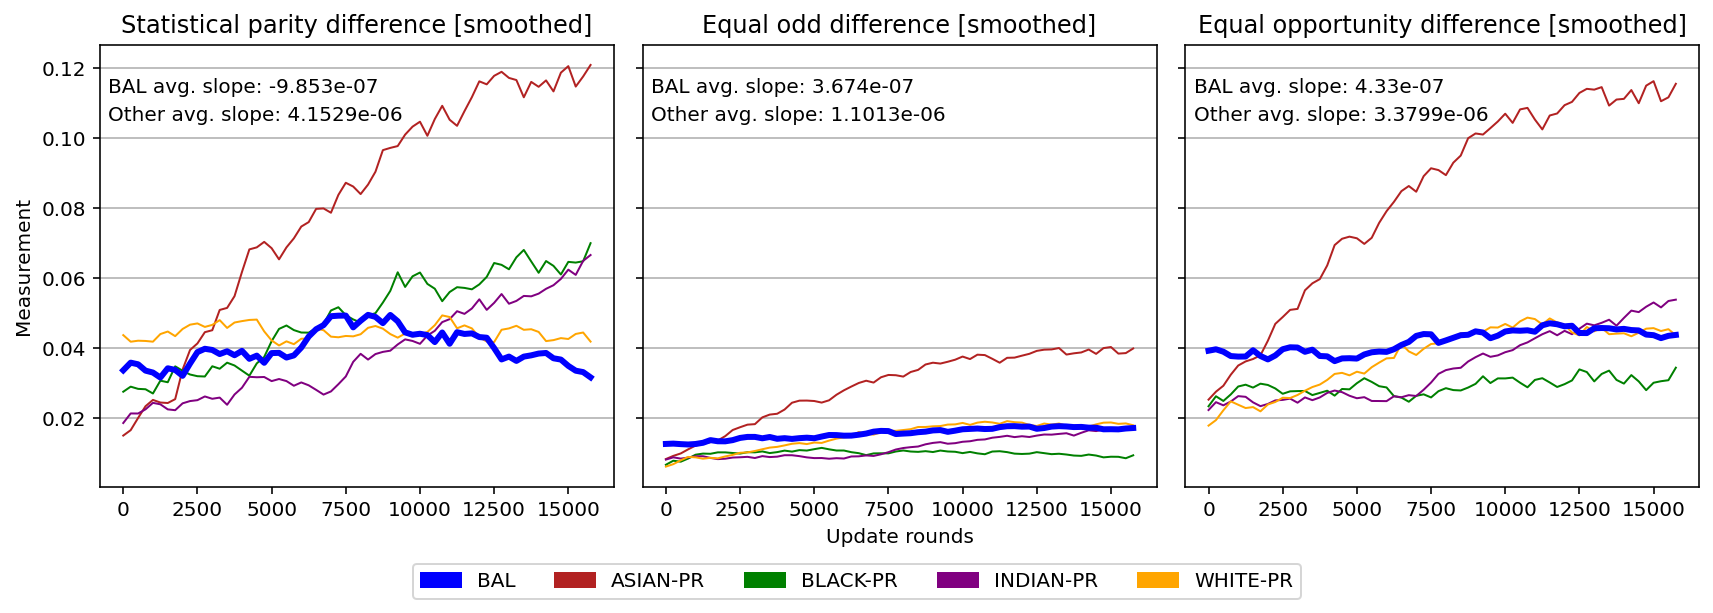

In [22]:
bal_c = 'blue'
a_c = 'firebrick'
b_c = 'green'
i_c = 'purple'
w_c = 'orange'

bal_patch = mpatches.Patch(color=bal_c, label='BAL')
a_patch = mpatches.Patch(color=a_c, label='ASIAN-PR')
b_patch = mpatches.Patch(color=b_c, label='BLACK-PR')
i_patch = mpatches.Patch(color=i_c, label='INDIAN-PR')
w_patch = mpatches.Patch(color=w_c, label='WHITE-PR')
imb_l_style = '-'
smoothed = '[smoothed]'

X_ax = np.arange(len(score_a))*250 

#SLOPES
SPD_bal_sl = avslope(X_ax, SPD_bal)
SPD_im_sl = avslope(X_ax, (np.array(SPD_a) + np.array(SPD_b) + np.array(SPD_i) + np.array(SPD_w)) / 4)

EOD_bal_sl = avslope(X_ax, EOD_bal)
EOD_im_sl = avslope(X_ax, (np.array(EOD_a) + np.array(EOD_b) + np.array(EOD_i) + np.array(EOD_w)) / 4)

EPD_bal_sl = avslope(X_ax, EPD_bal)
EPD_im_sl = avslope(X_ax, (np.array(EPD_a) + np.array(EPD_b) + np.array(EPD_i) + np.array(EPD_w)) / 4)


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True, tight_layout=True)
#fig.suptitle('Comparison of equality scores on balanced and imbalanced sets')
axs[0].title.set_text('Statistical parity difference ' + smoothed)
axs[0].plot(X_ax, smooth(SPD_a, .9), color=a_c, linewidth=1, linestyle=imb_l_style)
axs[0].plot(X_ax, smooth(SPD_b, .9), color=b_c, linewidth=1, linestyle=imb_l_style)
axs[0].plot(X_ax, smooth(SPD_i, .9), color=i_c, linewidth=1, linestyle=imb_l_style)
axs[0].plot(X_ax, smooth(SPD_w, .9), color=w_c, linewidth=1, linestyle=imb_l_style)
axs[0].plot(X_ax, smooth(SPD_bal, .9), color=bal_c, linewidth=3)

axs[0].text(-500, 0.113, 'BAL avg. slope: ' + str(round(SPD_bal_sl, 10)))
axs[0].text(-500, 0.105, 'Other avg. slope: ' + str(round(SPD_im_sl, 10)))

axs[0].set_ylabel('Measurement')


axs[0].grid(axis='y')

axs[1].title.set_text('Equal odd difference ' + smoothed)
axs[1].plot(X_ax, smooth(EOD_a, .9), color=a_c, linewidth=1, linestyle=imb_l_style)
axs[1].plot(X_ax, smooth(EOD_b, .9), color=b_c, linewidth=1, linestyle=imb_l_style)
axs[1].plot(X_ax, smooth(EOD_i, .9), color=i_c, linewidth=1, linestyle=imb_l_style)
axs[1].plot(X_ax, smooth(EOD_w, .9), color=w_c, linewidth=1, linestyle=imb_l_style)
axs[1].plot(X_ax, smooth(EOD_bal, .9), color=bal_c, linewidth=3)
axs[1].set_xlabel('Update rounds')

axs[1].text(-500, 0.113, 'BAL avg. slope: ' + str(round(EOD_bal_sl, 10)))
axs[1].text(-500, 0.105, 'Other avg. slope: ' + str(round(EOD_im_sl, 10)))

axs[1].grid(axis='y')

axs[2].title.set_text('Equal opportunity difference ' + smoothed)
axs[2].plot(X_ax, smooth(EPD_a, .9), color=a_c, linewidth=1, linestyle=imb_l_style)
axs[2].plot(X_ax, smooth(EPD_b, .9), color=b_c, linewidth=1, linestyle=imb_l_style)
axs[2].plot(X_ax, smooth(EPD_i, .9), color=i_c, linewidth=1, linestyle=imb_l_style)
axs[2].plot(X_ax, smooth(EPD_w, .9), color=w_c, linewidth=1, linestyle=imb_l_style)
axs[2].plot(X_ax, smooth(EPD_bal, .9), color=bal_c, linewidth=3)

axs[2].text(-500, 0.113, 'BAL avg. slope: ' + str(round(EPD_bal_sl, 10)))
axs[2].text(-500, 0.105, 'Other avg. slope: ' + str(round(EPD_im_sl, 10)))

axs[2].grid(axis='y')

fig.legend(handles=[bal_patch, a_patch, b_patch, i_patch, w_patch], ncol=5, loc='lower center', bbox_to_anchor=(0.5, -.07))

plt.savefig('src/comparison.eps', format='eps', bbox_inches='tight')
plt.show()

### Human evaluation & plots

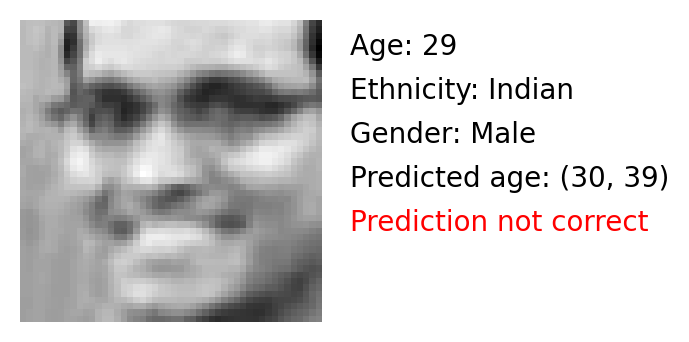

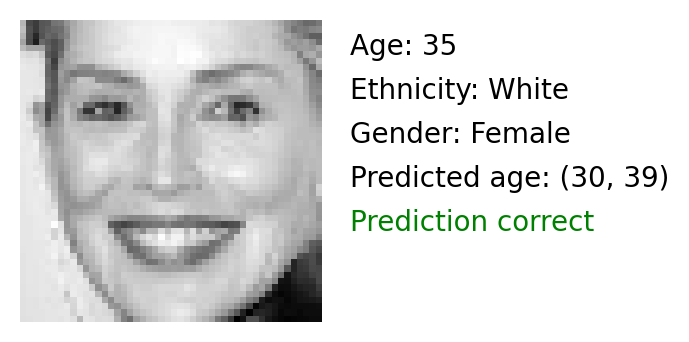

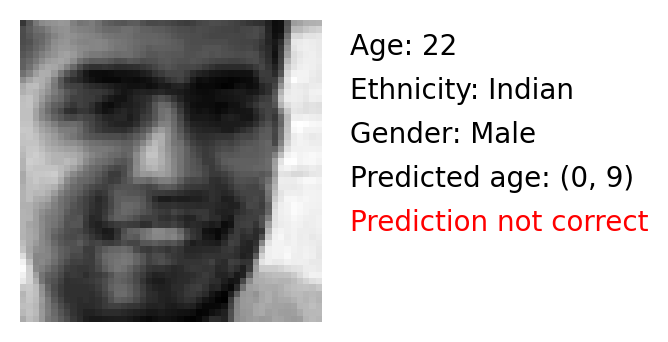

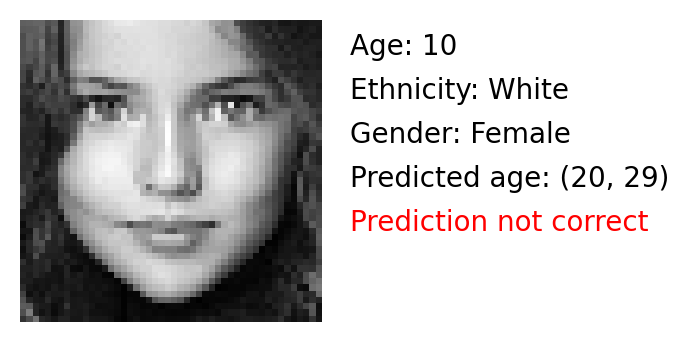

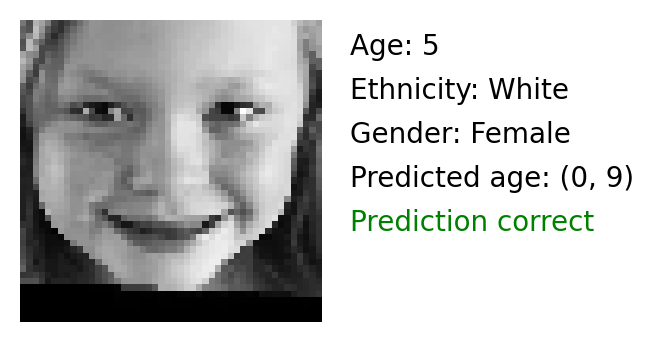

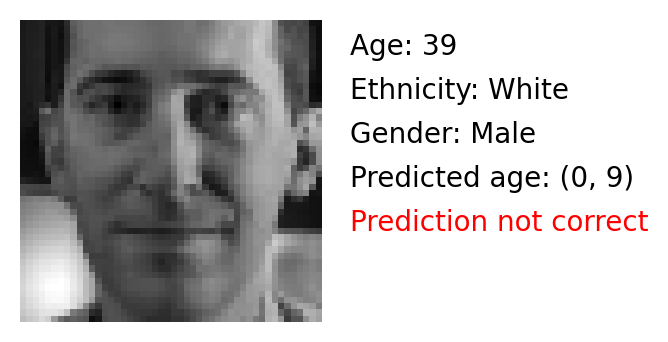

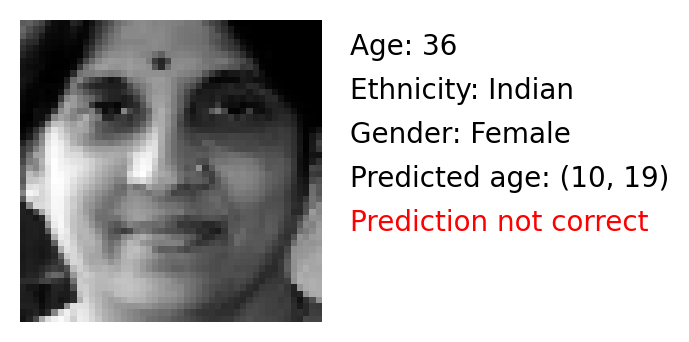

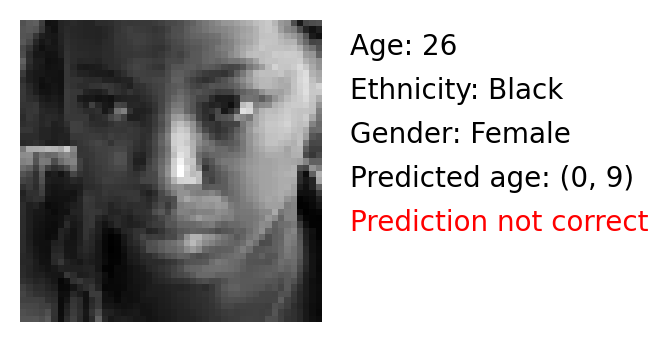

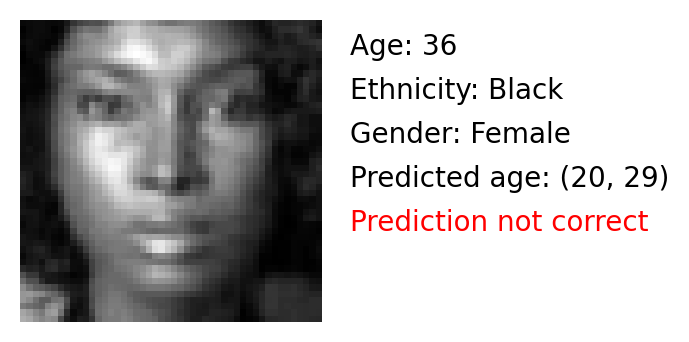

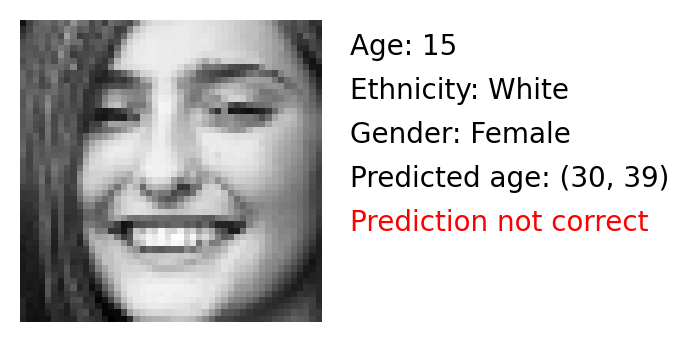

In [23]:
s_size = 10
s_bal_df = balanced_df.reset_index().sample(s_size).reset_index()
for idx in range(len(s_bal_df)):
    predict_row(s_bal_df, idx, models[1])